# Final Report
## Anomoly Detection Project
* Brian Oneill
* Scott Barnett
* Keila Camarillo
* Esayas Asefa

* 11 June 2023

## Goals
* Find the answers to the provided questions
* Deliver a final report to the data science team 
* Deliver a slide of findings to the Data Science team
* Deliver a professional email to the stakeholder reviewing our findings

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import env
import os
import wrangle
import functions

## Acquire

* Data acquired from the Codeup Database and the provided anonymized-curriculum-access.txt document 
    * Files were merged on id and cohort_id respectively
* It contained **900,223 rows and 8 columns**
* The data was aquired on **14 JUNE 2023**
* Each row represents a page access of the Codeup lesson server
* Each column represents a feature of the access event


## Prepare

* The only column with null values from the .txt file was cohort_id which we filled with 0
* After adding the sql pull to get the cohort's name, start_date, end-date, and program_id; nulls were created in those columns when cohort_id was 0. We filled those nulls with with "Unknown cohort", 2000-01-01, 2000-01-01, and 0 respectively.
* The date column was changed to a datetime, set as the index, and the index was sorted (earliest to latest)
* No columns were removed or renamed
* No additional features were added
* No encoding, scaling was accomplished
* Data was not split into train/validate/test for this analysis
* Outliers were not adressed as they were part of the target


### Data Dictionary

| Feature | Datatype | Key | Definition |
|---|---|---|---|
| date | datetime64 | YYYY-MM-DD | Date of activity; Index |
| endpoint | object | unique | In the url, everything after "...codeup.com/" |
| user_id | int64 | unique # | Unique ID # assigned to user |
| cohort_id | int64 | unique # | Unique ID # assigned to cohort |
| source_ip | object | IP ##.###.##.## | Unique IP address assigned to user device |
| name | object | unique | Name assigned to cohort |
| start_date | datetime64 | YYYY-MM-DD | Date cohort started |
| end_date | datetime64 | YYYY-MM-DD | Date cohort graduated |
| program_id | int64 | 1,2,3,4 | Program identifier: 1,2,4 - Webdev; 3 - Data Science |

### Bring in Data for Exploration

In [2]:
# Bringing in data and prparing it for exploration
df = wrangle.wrangle_curriculum_logs()

### Sneak Peak at the Data


In [3]:
df.head(3)

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,javascript-i/introduction/working-with-data-ty...,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/javascript-with-html,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 to 2021-04-21
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   endpoint    900222 non-null  object        
 1   user_id     900223 non-null  int64         
 2   cohort_id   900223 non-null  int64         
 3   source_ip   900223 non-null  object        
 4   name        900223 non-null  object        
 5   start_date  900223 non-null  datetime64[ns]
 6   end_date    900223 non-null  datetime64[ns]
 7   program_id  900223 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 61.8+ MB


### Summary of Data

In [5]:
df.describe()

,user_id,cohort_id,program_id
count,900223.000000,900223.000000,900223.000000
mean,458.825707,45.651349,1.963440
std,249.296767,33.800035,0.618478
min,1.000000,0.000000,0.000000
25%,269.000000,26.000000,2.000000
50%,475.000000,33.000000,2.000000
75%,660.000000,57.000000,2.000000
max,981.000000,139.000000,4.000000


## Exploration

* Questions 1,2,3,6, and 7 were selected for evaluation


### 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

#### Observations: 
* program_id 1 (WebDev): javascript-i is the most accessed lesson
* program_id 2 (WebDev): javascript-i is the most accessed lesson
* program_id 3 (Data Science): classification/overview is the most accessed lesson
* program_id 4 (Apollo cohort): only 4 rows in the dataset: content/html-css is the most accessed
* program_id 0 (UNKNOWN): javascript-i is the most accessed lesson 

In [6]:
# Get question 1 exploration - get top 5 pages of each program_id (0-4)
functions.question1_7(df, number=5, bottom=False)

Top 5 page access counts for program 0: 
endpoint
search/search_index.json    1985
javascript-i                 780
toc                          706
spring                       641
java-iii                     567
Name: endpoint, dtype: int64
---------------------------
Top 5 page access counts for program 1: 
endpoint
index.html      1011
javascript-i     736
html-css         542
spring           501
java-iii         479
Name: endpoint, dtype: int64
---------------------------
Top 5 page access counts for program 2: 
endpoint
javascript-i                17457
toc                         17428
search/search_index.json    15212
java-iii                    12683
html-css                    12569
Name: endpoint, dtype: int64
---------------------------
Top 5 page access counts for program 3: 
endpoint
search/search_index.json                    2203
classification/overview                     1785
1-fundamentals/modern-data-scientist.jpg    1655
1-fundamentals/AI-ML-DL-timeline.jpg      

### 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

####  Observations: 
* The only program where a cohort referred to a lesson significantly more than other cohorts was the Data Science program
    * The advanced-dataframes lesson was accessed a lot by Bayes, but very little by Curie and Darden
    * The Timeseries explore lesson was accessed a lot by Bayes and Curie, but very little by Darden

In [7]:
## After exploring, we decided to just look at a subset of the data that includes classes
#    that were active during the timespan of the data we have, to better understand class activity
## Get all the rows that are part of classes that started
#    after the start of our data and ended before the end of our data
subset_df = df[(df.start_date >= df.index[0].strftime(format='%Y-%m-%d')) &
               (df.end_date <= df.index[len(df)-1].strftime(format='%Y-%m-%d'))]

In [8]:
# break up subset_df into programs (1,2 are webdev, 3 is data science)
p0_df = subset_df[subset_df.program_id == 0]
p12_df = subset_df[subset_df['program_id'].isin([1,2])]
p3_df = subset_df[subset_df.program_id == 3]

In [9]:
# Data Science program (program_id == 3) is the only program with pages that have inconsistent access counts
functions.question2(p3_df, multiplier=3)

,endpoint,Bayes,Curie,Darden
0,4-python/7.4.4-advanced-dataframes,219,1,0
1,9-timeseries/4-explore,212,109,1


### 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

####  Observations: 
* There are 10 users in the dataset who, while active, accessed the curriculum <= 10 times
    * All users were in program 2
    * They were in 9 separate cohorts (2 users in the same cohort)
* Seven of the ten users accessed the curriculum on the first or second day of class only, indicating students who may have dropped out
* 3 of the 10 accessed the curriculum much later in the program
    * User 278, 812, 832 from Voyageurs, Hyperion, and Jupiter cohorts respectively
    * No good explanation for this: could be an error in capturing the data or some sort of unauthorized access 

In [10]:
# Get users that only access the curriculum a small amount of times
# For a smaller printout, we set limit to 1, but you can set it to 10 to see the results described above
functions.question3(df, limit=1)

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2020-03-23,/,619,57,97.105.19.58,Ganymede,2020-03-23,2020-08-20,2
2021-01-26,/,879,135,136.50.50.187,Marco,2021-01-25,2021-07-19,2
2021-03-15,/,940,138,70.121.129.79,Neptune,2021-03-15,2021-09-03,2
2021-03-15,/,918,138,71.221.46.112,Neptune,2021-03-15,2021-09-03,2


### 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

####  Observations: 
* As seen in the chart below the most referenced topics after graduation are:
    * Web Development - Java and Javascript
    * Data Science - SQL and classification

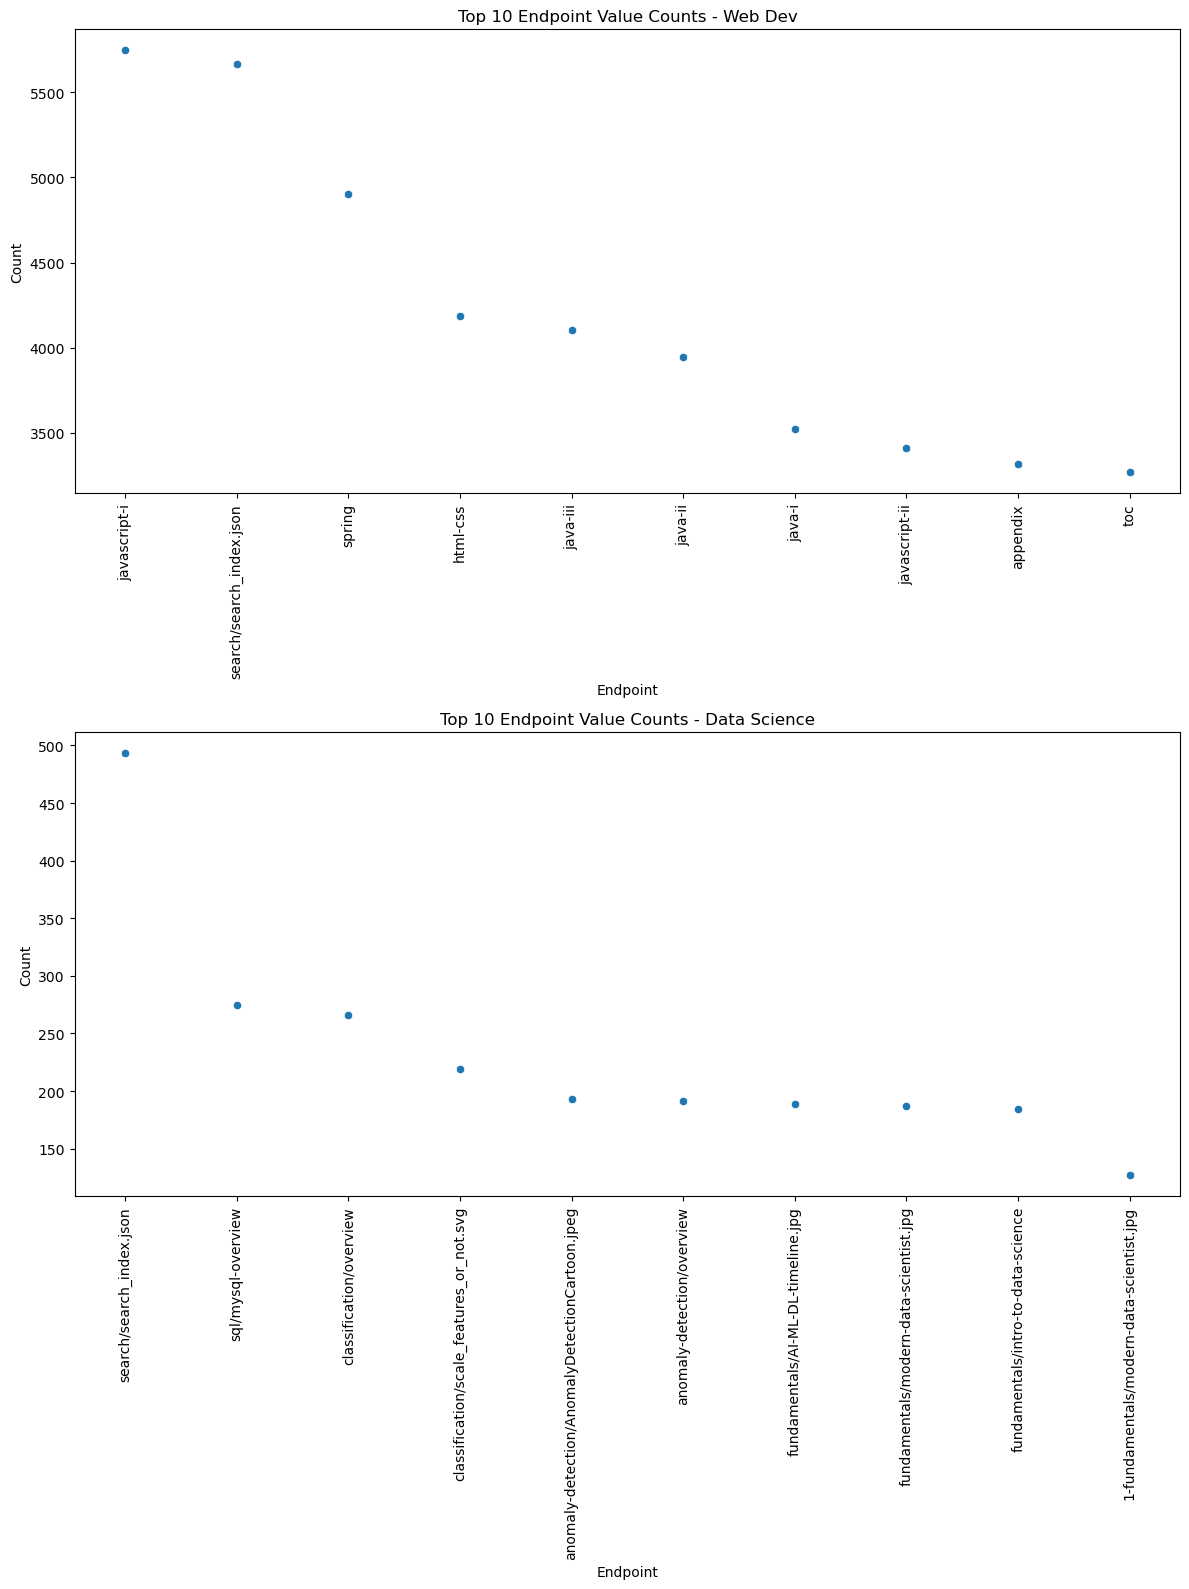

In [11]:
# Plot top 10 page access counts occuring post graduation
functions.question6(df)

### 7. Which lessons are least accessed?

####  Observations: 
* 457 pages were accessed only once in the dataset
* It is unknown how many pages were not accessed at all as that info is not in the dataset
* Of the 457 pages accessed only once, here are a few trends by program. (This will take some more analysis):
    * program_id 1 (WebDev): jquery pages are low-access
    * program_id 2 (WebDev): cli pages are low-access
    * program_id 3 (Data Science): storytelling, classification
    * program_id 4 (Apollo cohort): only 4 rows in the dataset: content/html-css is all that was accessed
    * program_id 0 (UNKNOWN): classification lessons are low-access

In [12]:
# Question 7 exploration: get the number of pages that were accessed only once
pages = df.endpoint.value_counts()
pages[pages == 1].shape

(457,)

In [13]:
# Question 7 exploration - - get bottom 5 pages of each program_id (0-4)
functions.question1_7(df, number=5, bottom=True)

Bottom 5 page access counts for program 0: 
endpoint
fundamentals/DataToAction_v2.jpg              1
7-classification/ensemble                     1
content/git/initializing-a-repository.html    1
7-classification/confusion-matrix             1
7-classification/6.4-knn                      1
Name: endpoint, dtype: int64
---------------------------
Bottom 5 page access counts for program 1: 
endpoint
html-css/media-queries                              1
content/jquery/events/keyboard-events.html          1
content/jquery/events/gitbook/images/favicon.ico    1
content/jquery/events                               1
content/jquery/essential-methods/traversing.html    1
Name: endpoint, dtype: int64
---------------------------
Bottom 5 page access counts for program 2: 
endpoint
'                                        1
classification/user-defined-functions    1
cli-02-listing-files                     1
cli-03-file-paths                        1
cli-07-more-topics                       1
Na

## Exploration Summary
* 1. The lessons with the most traffic consistently across cohorts (per program) are:
    * WebDev (Pro.1): javascript-i 
    * WebDev (Pro.2): javascript-i 
    * Data Science (Pro.3): classification/overview is the most accessed lesson
    * Apollo cohort (Pro.4):  content/html-css 
    * Unkown Grouo (Pro.0): javascript-i 
* 2. The only program where a cohort that referred to a lesson significantly more than other cohorts was the Data Science program
    * The advanced-dataframes lesson was accessed a lot by Bayes, but very little by Curie and Darden
    * The Timeseries explore lesson was accessed a lot by Bayes and Curie, but very little by Darden
* 3. There are 10 users in the dataset who, while active, accessed the curriculum <= 10 times
        * All users were in program 2
        * They were in 9 separate cohorts (2 users in the same cohort)
    * Seven of the ten users accessed the curriculum on the first or second day of class only, indicating students who may have dropped out
    * 3 of the 10 accessed the curriculum much later in the program
        * User 278, 812, 832 from Voyageurs, Hyperion, and Jupiter cohorts respectively
        * No good explanation for this: could be an error in capturing the data or some sort of unauthorized access
* 6. The most referenced topics after graduation are:
    * Web Development - Java and Javascript
    * Data Science - SQL and classification
* 7. Lesson accessed the least is collection of 457 lesson pages that were only accessed once.

## Report - Conclusion
* We were able to address 5 of the 7 questions asked
### Summary
1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
    * The lessons withe most traffic consistently across cohorts (per program) are:
        * WebDev Programs 1, 2 and unassigned:  javascript-i 
        * Data Science Program 3: classification overview 

2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
    * The only program where a cohort that referred to a lesson significantly more than other cohorts was the Data Science program
        * The advanced-dataframes lesson was accessed a lot by Bayes, but very little by Curie and Darden
        * The Timeseries explore lesson was accessed a lot by Bayes and Curie, but very little by Darden

3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
    * There are 10 users in the dataset who, while active, accessed the curriculum <= 10 times
        * All users were in program 2
        * They were in 9 separate cohorts (2 users in the same cohort)
    * Seven of the ten users accessed the curriculum on the first or second day of class only, indicating students who may have dropped out
    * 3 of the 10 accessed the curriculum much later in the program
        * User 278, 812, 832 from Voyageurs, Hyperion, and Jupiter cohorts respectively
        * No good explanation for this: could be an error in capturing the data or some sort of unauthorized access

6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
	* The most referenced topics after graduation are: 
		* Web Development - Java and Javascript
	    * Data Science - SQL and classification

7. Which lessons are least accessed?
    * Lesson accessed the least is collection of 457 lesson pages that were only accessed once

### Recommendations

* Provide additional takeaways or downloadable docs for extensively used topics
* Investigate the need to redo or reorganize the information on the 457 seldom used pages

### Next Steps
* If provided more time we could have looked further into the additional two questions, and connected unknown users to cohorts